# Testing Graphical User Interfaces

In this chapter, we explore how to generate tests for Graphical User Interfaces (GUIs), abstracting from our [previous examples on Web testing](WebFuzzer.ipynb).  Building on general means to extract user interface elements and to activate them, our techniques generalize to arbitrary graphical user interfaces, from rich Web applications to mobile apps, and systematically explore user interfaces through forms and navigation elements.

**Prerequisites**

* We build on the Web server introduced in the [chapter on Web testing](WebFuzzer.ipynb).

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from fuzzingbook.GUIFuzzer import <identifier>
```

and then make use of the following features.


This chapter demonstrates how to programmatically interact with user interfaces, using Selenium on Web browsers.  It provides an experimental  `GUICoverageFuzzer` class that automatically explores a user interface by systematically interacting with all available user interface elements.

The function `start_webdriver()` starts a headless Web browser in the background and returns a _GUI driver_ as handle for further communication.

```python
>>> gui_driver = start_webdriver()
```
We let the browser open the URL of the server we want to investigate (in this case, the vulnerable server from [the chapter on Web fuzzing](WebFuzzer.ipynb)) and obtain a screen shot.

```python
>>> gui_driver.get(httpd_url)
>>> Image(gui_driver.get_screenshot_as_png())
```
The `GUICoverageFuzzer` class explores the user interface and builds a _grammar_ that encodes all states as well as the user interactions required to move from one state to the next.  It is paired with a `GUIRunner` which interacts with the GUI driver.

```python
>>> gui_fuzzer = GUICoverageFuzzer(gui_driver)
>>> gui_runner = GUIRunner(gui_driver)
```
The `explore_all()` method extracts all states and all transitions from a Web user interface.

```python
>>> gui_fuzzer.explore_all(gui_runner)
```
The grammar embeds a finite state automation and is best visualized as such.

```python
>>> fsm_diagram(gui_fuzzer.grammar)
```
The GUI Fuzzer `fuzz()` method produces sequences of interactions that follow paths through the finite state machine.  Since `GUICoverageFuzzer` is derived from `CoverageFuzzer` (see the [chapter on coverage-based grammar fuzzing](GrammarCoverageFuzzer.ipynb)), it automatically covers (a) as many transitions between states as well as (b) as many form elements as possible.  In our case, the first set of actions explores the transition via the "order form" link; the second set then goes until the "<end>" state.

```python
>>> gui_driver.get(httpd_url)
>>> actions = gui_fuzzer.fuzz()
>>> print(actions)
```
These actions can be fed into the GUI runner, which will execute them on the given GUI driver.

```python
>>> gui_driver.get(httpd_url)
>>> result, outcome = gui_runner.run(actions)
>>> Image(gui_driver.get_screenshot_as_png())
```
Further invocations of `fuzz()` will further cover the model – for instance, exploring the terms and conditions.

A tool like `GUICoverageFuzzer` will provide "deep" exploration of user interfaces, even filling out forms to explore what is behind them. Keep in mind, though, that `GUICoverageFuzzer` is experimental: It only supports a subset of HTML form and link features, and does not take JavaScript into account.



## Automated GUI Interaction

In the [chapter on Web testing](WebFuzzer.ipynb), we have shown how to test Web-based interfaces by directly interacting with a Web server using the HTTP protocol, and processing the retrieved HTML pages to identify user interface elements.  While these techniques work well for user interfaces that are based on HTML only, they fail as soon as there are interactive elements that use JavaScript to execute code within the browser, and generate and change the user interface without having to interact with the browser.

In this chapter, we therefore take a different approach to user interface testing.  Rather than using HTTP and HTML as the mechanisms for interaction, we leverage a dedicated _UI testing framework_, which allows us to

* query the program under test for available user interface elements, and
* query the UI elements for how they can be interacted with.

Although we will again illustrate our approach using a Web server, the approach easily generalizes to _arbitrary user interfaces_.  In fact, the UI testing framework we use, *Selenium*, also comes in variants that run for Android apps.

### Our Web Server, Again

As in the [chapter on Web testing](WebFuzzer.ipynb), we run a Web server that allows us to order products.

In [1]:
import bookutils

In [2]:
import os
import sys

In [3]:
# ignore
if 'CI' in os.environ:
    # Can't run this in our continuous environment,
    # since it can't run a headless Web browser
    sys.exit(0)

In [4]:
from WebFuzzer import init_db, start_httpd, webbrowser, print_httpd_messages, print_url, ORDERS_DB

In [5]:
import html

In [6]:
db = init_db()

This is the address of our web server:

In [7]:
httpd_process, httpd_url = start_httpd()
print_url(httpd_url)

Using `webbrowser()`, we can retrieve the HTML of the home page, and use `HTML()` to render it.

In [8]:
from IPython.display import display, Image

In [9]:
from bookutils import HTML, rich_output

In [10]:
HTML(webbrowser(httpd_url))

### Remote Control with Selenium

Let us take a look at the GUI above.  In contrast to the [chapter on Web testing](WebFuzzer.ipynb), we do not assume we can access the HTML source of the current page.  All we assume is that there is a set of *user interface elements* we can interact with.

[Selenium](https://www.seleniumhq.org) is a framework for testing Web applications by _automating interaction in the browser_.  Selenium provides an API that allows one to launch a Web browser, query the state of the user interface, and interact with individual user interface elements.  The Selenium API is available in a number of languages; we use the [Selenium API for Python](https://selenium-python.readthedocs.io/index.html).

A Selenium *web driver* is the interface between a program and a browser controlled by the program.

In [11]:
from selenium import webdriver

The following code starts a Firefox browser in the background, which we then control through the web driver.

In [12]:
BROWSER = 'firefox'

**Note:** If you don't have Firefox installed, you can also set `BROWSER` to `'chrome'` to use Google Chrome instead.

In [13]:
# BROWSER = 'chrome'

**Note:** For Firefox, you may have to make sure the [geckodriver program](https://github.com/mozilla/geckodriver/releases) is in your path.

In [14]:
import shutil

In [15]:
if BROWSER == 'firefox':
    assert shutil.which('geckodriver') is not None, \
    "Please install 'geckodriver' executable " \
    "from https://github.com/mozilla/geckodriver/releases"

The browser is _headless_, meaning that it does not show on the screen.

In [16]:
HEADLESS = True

**Note**: If the notebook server runs locally (i.e. on the same machine on which you are seeing this), you can also set `HEADLESS` to `False` and see what happens right on the screen as you execute the notebook cells.  This is very much recommended for interactive sessions.

In [17]:
def start_webdriver(browser=BROWSER, headless=HEADLESS, zoom=1.4):
    if browser == 'firefox':
        options = webdriver.FirefoxOptions()
    if browser == 'chrome':
        options = webdriver.ChromeOptions()

    if headless and browser == 'chrome':
        options.add_argument('headless')
    else:
        options.headless = headless
    
    # Start the browser, and obtain a _web driver_ object such that we can interact with it.
    if browser == 'firefox':
        # For firefox, set a higher resolution for our screenshots
        profile = webdriver.firefox.firefox_profile.FirefoxProfile()
        profile.set_preference("layout.css.devPixelsPerPx", repr(zoom))
        gui_driver = webdriver.Firefox(firefox_profile=profile, options=options)
        
        # We set the window size such that it fits our order form exactly;
        # this is useful for not wasting too much space when taking screen shots.
        gui_driver.set_window_size(700, 300)

    elif browser == 'chrome':
        gui_driver = webdriver.Chrome(options=options)
        gui_driver.set_window_size(700, 210 if headless else 340)
            
    return gui_driver

In [18]:
gui_driver = start_webdriver(browser=BROWSER, headless=HEADLESS)

We can now interact with the browser programmatically.  First, we have it navigate to the URL of our Web server:

In [19]:
gui_driver.get(httpd_url)

We see that the home page is actually accessed, together with a (failing) request to get a page icon:

In [20]:
print_httpd_messages()

To see what the "headless" browser displays, we can obtain a screenshot.  We see that it actually displays the home page.

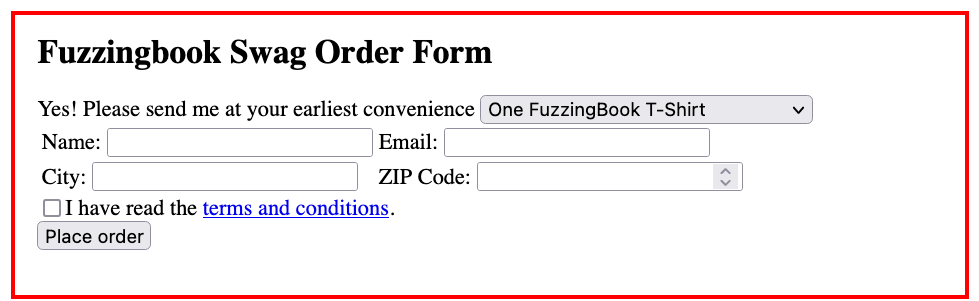

In [21]:
Image(gui_driver.get_screenshot_as_png())

### Filling out Forms

To interact with the Web page through Selenium and the browser, we can _query_ Selenium for individual elements.  For instance, we can access the UI element whose `name` attribute (as defined in HTML) is `"name"`.

In [22]:
name = gui_driver.find_element_by_name("name")

Once we have an element, we can interact with it.  Since `name` is a text field, we can send it a string using the `send_keys()` method; the string will be translated into appropriate key strokes.

In [23]:
name.send_keys("Jane Doe")

In the screenshot, we can see that the `name` field is now filled:

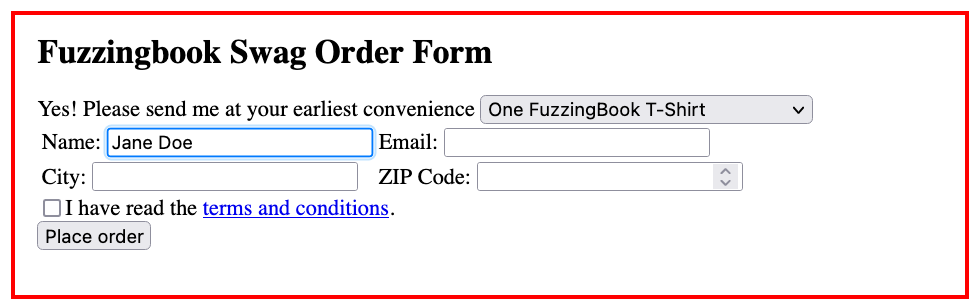

In [24]:
Image(gui_driver.get_screenshot_as_png())

In a similar fashion, we can fill out the email, city, and ZIP fields:

In [25]:
email = gui_driver.find_element_by_name("email")
email.send_keys("j.doe@example.com")

In [26]:
city = gui_driver.find_element_by_name('city')
city.send_keys("Seattle")

In [27]:
zip = gui_driver.find_element_by_name('zip')
zip.send_keys("98104")

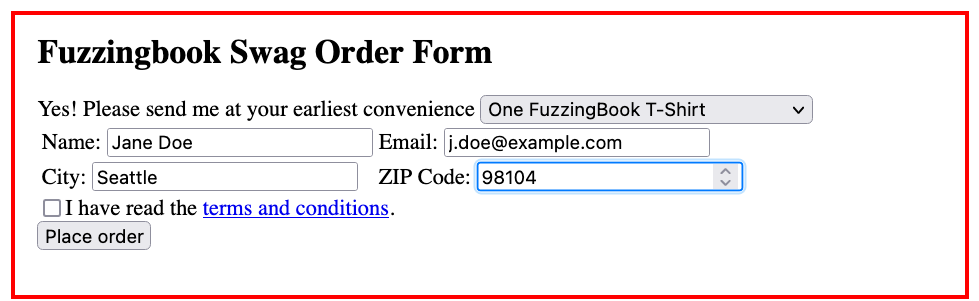

In [28]:
Image(gui_driver.get_screenshot_as_png())

The check box for terms and conditions is not filled out, but clicked instead using the `click()` method.

In [29]:
terms = gui_driver.find_element_by_name('terms')
terms.click()

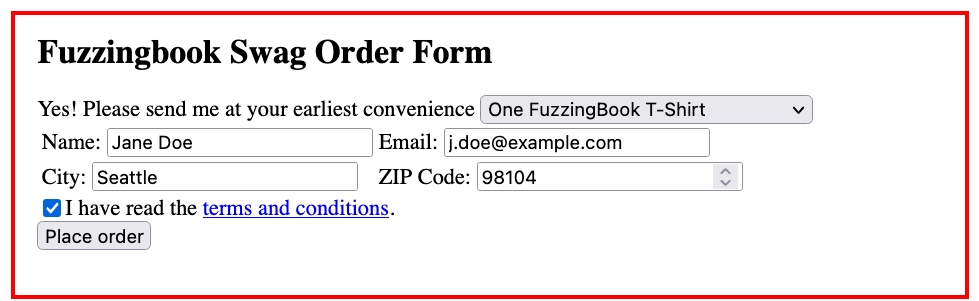

In [30]:
Image(gui_driver.get_screenshot_as_png())

The form is now fully filled out.  By clicking on the `submit` button, we can place the order:

In [31]:
submit = gui_driver.find_element_by_name('submit')
submit.click()

We see that the order is being processed, and that the Web browser has switched to the confirmation page.

In [32]:
print_httpd_messages()

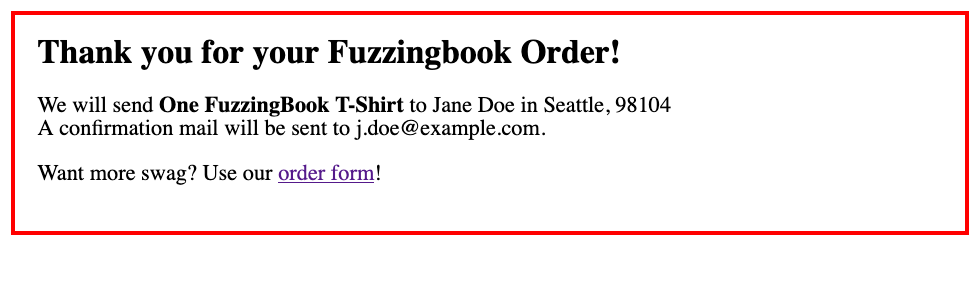

In [33]:
Image(gui_driver.get_screenshot_as_png())

### Navigating

Just as we fill out forms, we can also navigate through a Web site by clicking on links.  Let us go back to the home page:

In [34]:
gui_driver.back()

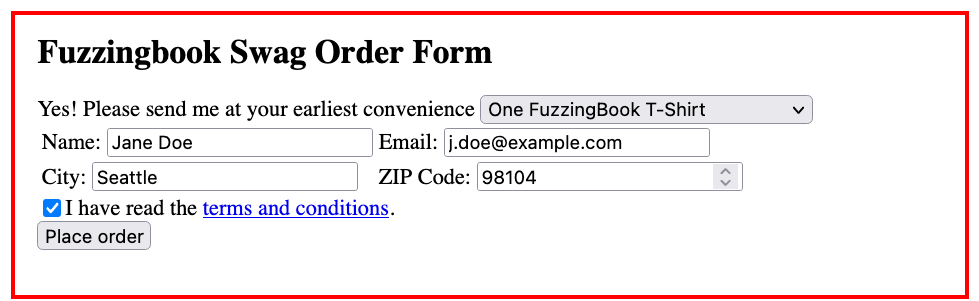

In [35]:
Image(gui_driver.get_screenshot_as_png())

We can query the web driver for all elements of a particular type.  Querying for HTML anchor elements (`<a>`) for instance, gives us all links on a page.

In [36]:
links = gui_driver.find_elements_by_tag_name("a")

We can query the attributes of UI elements – for instance, the URL the first anchor on the page links to:

In [37]:
links[0].get_attribute('href')

'http://127.0.0.1:8800/terms'

What happens if we click on it?  Very simple: We switch to the Web page being referenced.

In [38]:
links[0].click()

In [39]:
print_httpd_messages()

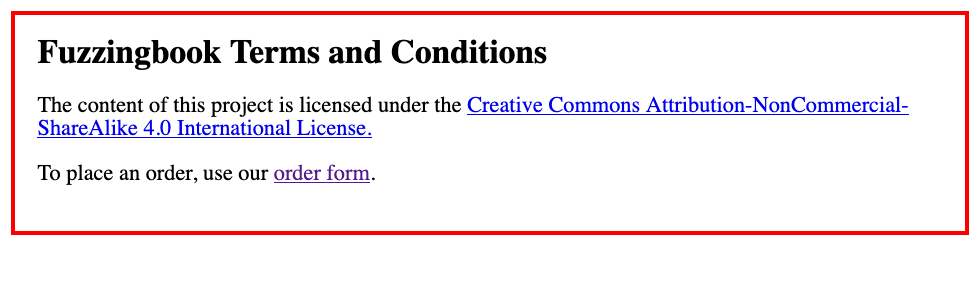

In [40]:
Image(gui_driver.get_screenshot_as_png())

Okay.  Let's get back to our home page again.

In [41]:
gui_driver.back()

In [42]:
print_httpd_messages()

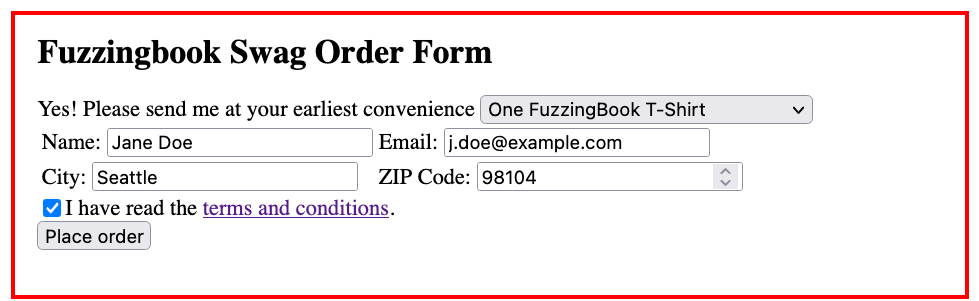

In [43]:
Image(gui_driver.get_screenshot_as_png())

### Writing Test Cases

The above calls, interacting with a user interface automatically, are typically used in *Selenium tests* – that is, code snippets that interact with a Web site, occasionally checking whether everything works as expected.  The following code, for instance, places an order just as above.  It then retrieves the `title` element and checks whether the title contains a "Thank you" message, indicating success.

In [44]:
def test_successful_order(driver, url):
    name = "Walter White"
    email = "white@jpwynne.edu"
    city = "Albuquerque"
    zip_code = "87101"
    
    driver.get(url)
    driver.find_element_by_name("name").send_keys(name)
    driver.find_element_by_name("email").send_keys(email)
    driver.find_element_by_name('city').send_keys(city)
    driver.find_element_by_name('zip').send_keys(zip_code)
    driver.find_element_by_name('terms').click()
    driver.find_element_by_name('submit').click()
    
    title = driver.find_element_by_id('title')
    assert title is not None
    assert title.text.find("Thank you") >= 0

    confirmation = driver.find_element_by_id("confirmation")
    assert confirmation is not None

    assert confirmation.text.find(name) >= 0
    assert confirmation.text.find(email) >= 0
    assert confirmation.text.find(city) >= 0
    assert confirmation.text.find(zip_code) >= 0
    
    return True

In [45]:
test_successful_order(gui_driver, httpd_url)

True

In a similar vein, we can set up automated test cases for unsuccessful orders, canceling orders, changing orders, and many more.  All these test cases would be automatically run after any change to the program code, ensuring the Web application still works.

Of course, writing such tests is quite some effort.  Hence, in the remainder of this chapter, we will again explore how to automatically generate them.

## Retrieving User Interface Actions

To automatically interact with a user interface, we first need to find out which elements there are, and which user interactions (or short *actions*) they support.

### User Interface Elements

We start with finding available user elements.  Let us get back to the order form.

In [46]:
gui_driver.get(httpd_url)

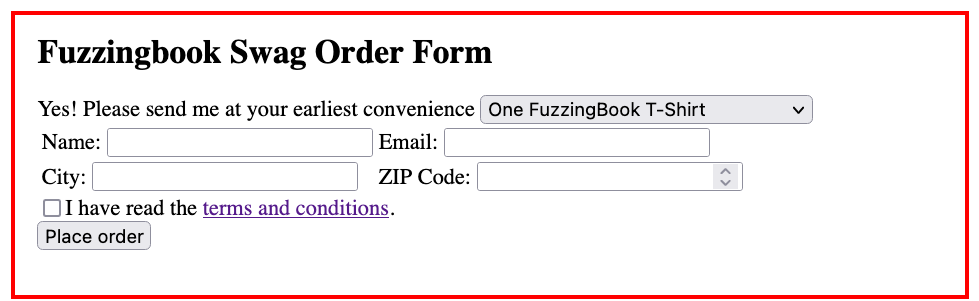

In [47]:
Image(gui_driver.get_screenshot_as_png())

Using `find_elements_by_tag_name()` (and other similar `find_elements_...()` functions), we can retrieve all elements of a particular type, such as HTML `input` elements.

In [48]:
ui_elements = gui_driver.find_elements_by_tag_name("input")

For each element, we can retrieve its HTML attributes, using `get_attribute()`.  We can thus retrieve the `name` and `type` of each input element (if defined).

In [49]:
for element in ui_elements:
    print("Name: %-10s | Type: %-10s | Text: %s" % (element.get_attribute('name'), element.get_attribute('type'), element.text))

Name: name       | Type: text       | Text: 
Name: email      | Type: email      | Text: 
Name: city       | Type: text       | Text: 
Name: zip        | Type: number     | Text: 
Name: terms      | Type: checkbox   | Text: 
Name: submit     | Type: submit     | Text: 


In [50]:
ui_elements = gui_driver.find_elements_by_tag_name("a")

In [51]:
for element in ui_elements:
    print("Name: %-10s | Type: %-10s | Text: %s" % (element.get_attribute('name'), element.get_attribute('type'), element.text))

Name:            | Type:            | Text: terms and conditions


### User Interface Actions

Similarly to what we did in the [chapter on Web fuzzing](WebFuzzer.ipynb), our idea is now to mine a _grammar_ for the user interface – first for an individual user interface *page* (i.e., a single Web page), later for all pages offered by the application.  The idea is that a grammar defines _legal sequences of actions_ – clicks and keystrokes – that can be applied on the application.

We assume the following actions:

1. `fill(<name>, <text>)` – fill the UI input element named `<name>` with the text `<text>`.
1. `check(<name>, <value>)` – set the UI checkbox `<name>` to the given value `<value>` (True or False)
1. `submit(<name>)` – submit the form by clicking on the UI element `<name>`.
1. `click(<name>)` – click on the UI element `<name>`, typically for following a link.

This sequence of actions, for instance would fill out the order form:

```python
fill('name', "Walter White")
fill('email', "white@jpwynne.edu")
fill('city', "Albuquerque")
fill('zip', "87101")
check('terms', True)
submit('submit')
```

Our set of actions is deliberately defined to be small – for real user interfaces, one would also have to define interactions such as swipes, double clicks, long clicks, right button clicks, modifier keys, and more.  Selenium supports all of this; but in the interest of simplicity, we focus on the most important set of interactions.

### Retrieving Actions

As a first step in mining an action grammar, we need to be able to retrieve possible interactions.  We introduce a class `GUIGrammarMiner`, which is set to do precisely that.

In [52]:
class GUIGrammarMiner(object):
    def __init__(self, driver, stay_on_host=True):
        self.driver = driver
        self.stay_on_host = stay_on_host
        self.grammar = {}

Our first task is to obtain the set of possible interactions.  Given a single UI page, the method `mine_input_actions()` of `GUIGrammarMiner` returns a set of *actions* as defined above.  It first gets all `input` elements, followed by `button` elements, finally followed by links (`a` elements), and merges them into a set.  (We use a `frozenset` here since we want to use the set as an index later.)

In [53]:
class GUIGrammarMiner(GUIGrammarMiner):
    def mine_state_actions(self):
        return frozenset(self.mine_input_element_actions()
            | self.mine_button_element_actions()
            | self.mine_a_element_actions())

#### Input Element Actions

Mining input actions goes through the set of input elements, and returns an action depending on the input type.  If the input field is a text, for instance, the associated action is `fill()`; for checkboxes, the action is `check()`.

The respective values are placeholders depending on the type; if the input field is a number, for instance, the value becomes `<number>`.  As these actions later become part of the grammar, they will be expanded into actual values during grammar expansion.

In [54]:
from selenium.common.exceptions import StaleElementReferenceException

In [55]:
class GUIGrammarMiner(GUIGrammarMiner):
    def mine_input_element_actions(self):
        actions = set()
        
        for elem in self.driver.find_elements_by_tag_name("input"):
            try:
                input_type = elem.get_attribute("type")
                input_name = elem.get_attribute("name")
                if input_name is None:
                    input_name = elem.text

                if input_type in ["checkbox", "radio"]:
                    actions.add("check('%s', <boolean>)" % html.escape(input_name))
                elif input_type in ["text", "number", "email", "password"]:
                    actions.add("fill('%s', '<%s>')" % (html.escape(input_name), html.escape(input_type)))
                elif input_type in ["button", "submit"]:
                    actions.add("submit('%s')" % html.escape(input_name))
                elif input_type in ["hidden"]:
                    pass
                else:
                    # TODO: Handle more types here
                    actions.add("fill('%s', <%s>)" % (html.escape(input_name), html.escape(input_type)))
            except StaleElementReferenceException:
                pass

        return actions

Applied on our order form, we see that the method gets us all input actions:

In [56]:
gui_grammar_miner = GUIGrammarMiner(gui_driver)
gui_grammar_miner.mine_input_element_actions()

{"check('terms', <boolean>)",
 "fill('city', '<text>')",
 "fill('email', '<email>')",
 "fill('name', '<text>')",
 "fill('zip', '<number>')",
 "submit('submit')"}

#### Button Element Actions

Mining buttons works in a similar way:

In [57]:
class GUIGrammarMiner(GUIGrammarMiner):
    def mine_button_element_actions(self):
        actions = set()
        
        for elem in self.driver.find_elements_by_tag_name("button"):
            try:
                button_type = elem.get_attribute("type")
                button_name = elem.get_attribute("name")
                if button_name is None:
                    button_name = elem.text
                if button_type == "submit":
                    actions.add("submit('%s')" % html.escape(button_name))
                elif button_type != "reset":
                    actions.add("click('%s')" % html.escape(button_name))
            except StaleElementReferenceException:
                pass

        return actions

Our order form has no `button` elements.  (The `submit` button is an `input` element, and was handled above).

In [58]:
gui_grammar_miner = GUIGrammarMiner(gui_driver)
gui_grammar_miner.mine_button_element_actions()

set()

#### Link Element Actions

When following links, we need to make sure that we stay on the current host – we want to explore a single Web site only, not all of the Internet.  To this end, we check the `href` attribute of the link to check whether it still points to the same host.  If it does not, we give it a special action `ignore()`, which, as the name suggests, will later be ignored as it comes to executing these actions.  We still return an action, though, as we use the set of actions to characterize a state in the application.

In [59]:
class GUIGrammarMiner(GUIGrammarMiner):
    def mine_a_element_actions(self):
        actions = set()

        for elem in self.driver.find_elements_by_tag_name("a"):
            try:
                a_href = elem.get_attribute("href")
                if a_href is not None:
                    if self.follow_link(a_href):
                        actions.add("click('%s')" % html.escape(elem.text))
                    else:
                        actions.add("ignore('%s')" % html.escape(elem.text))
            except StaleElementReferenceException:
                pass

        return actions

To check whether we can follow a link, the method `follow_link()` checks the URL:

In [60]:
from urllib.parse import urljoin, urlsplit

In [61]:
class GUIGrammarMiner(GUIGrammarMiner):
    def follow_link(self, link):
        if not self.stay_on_host:
            return True
        
        current_url = self.driver.current_url
        target_url = urljoin(current_url, link)
        return urlsplit(current_url).hostname == urlsplit(target_url).hostname       

In our application, we would not be allowed to follow a link to `foo.bar`:

In [62]:
gui_grammar_miner = GUIGrammarMiner(gui_driver)

In [63]:
gui_grammar_miner.follow_link("ftp://foo.bar/")

False

Following a link to `localhost`, though, works well:

In [64]:
gui_grammar_miner.follow_link("https://127.0.0.1/")

True

When adapting this for other user interfaces, similar measures would be taken to ensure we stay in the same application.

Running this method on our page gets us the set of links:

In [65]:
gui_grammar_miner = GUIGrammarMiner(gui_driver)
gui_grammar_miner.mine_a_element_actions()

{"click('terms and conditions')"}

#### All Together

Let us now apply `mine_state_actions()` on our current page to retrieve all elements.  We see that we get the union of all three sets.

In [66]:
gui_grammar_miner = GUIGrammarMiner(gui_driver)
gui_grammar_miner.mine_state_actions()

frozenset({"check('terms', <boolean>)",
           "click('terms and conditions')",
           "fill('city', '<text>')",
           "fill('email', '<email>')",
           "fill('name', '<text>')",
           "fill('zip', '<number>')",
           "submit('submit')"})

We assume that we can identify a user interface *state* from the set of interactive elements it contains – that is, the current Web page is identified by the set above.  This is in contrast to [Web fuzzing](WebFuzzer.ipynb), where we assumed the URL to uniquely characterize a page – but with JavaScript, the URL can stay unchanged although the page contents change, and UIs other than the Web may have no concept of unique URLs.  Therefore, we say that the way a UI can be interacted with uniquely defines its state.

## Models for User Interfaces

### User Interfaces as Finite State Machines

Now that we can retrieve UI elements from a page, let us go and systematically explore a user interface.  The idea is to represent the user interface as a *finite state machine* – that is, a sequence of *states* that can be reached by interacting with the individual user interface elements.

Let us illustrate such a finite state machine by looking at our Web server.  The following diagram shows the states our server can be in:

In [67]:
# ignore
from graphviz import Digraph

In [68]:
# ignore
from IPython.display import display

In [69]:
# ignore
from GrammarFuzzer import dot_escape

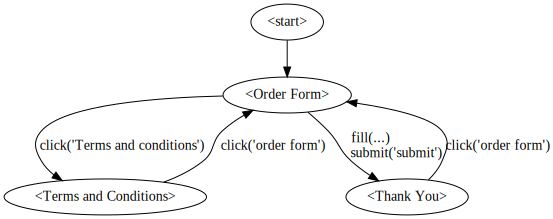

In [70]:
# ignore
dot = Digraph(comment="Finite State Machine")
dot.node(dot_escape('<start>'))
dot.edge(dot_escape('<start>'), dot_escape('<Order Form>'))
dot.edge(dot_escape('<Order Form>'), dot_escape('<Terms and Conditions>'), "click('Terms and conditions')")
dot.edge(dot_escape('<Order Form>'), dot_escape('<Thank You>'), r"fill(...)\lsubmit('submit')")
dot.edge(dot_escape('<Terms and Conditions>'), dot_escape('<Order Form>'), "click('order form')")
dot.edge(dot_escape('<Thank You>'), dot_escape('<Order Form>'), "click('order form')")
display(dot)

Initially, we are in the `<Order Form>` state.  From here, we can click on `Terms and Conditions`, and we'll be in the `Terms and Conditions` state, showing the page with the same title.  We can also fill out the form and place the order, having us end in the `Thank You` state (again showing the page with the same title).  From both `<Terms and Conditions>` and `<Thank You>`, we can return to the order form by clicking on the `order form` link.

### State Machines as Grammars

To systematically explore a user interface, we must retrieve its finite state machine, and eventually cover all states and transitions.  In the presence of forms, such an exploration is difficult, as we need a special mechanism to fill out forms and submit the values to get to the next state.  There is a trick, though, which allows us to have a single representation for both states and (form) values.  We can *embed the finite state machine into a grammar*, which is then used for both states and form values.

To embed a finite state machine into a grammar, we proceed as follows:

1. Every _state_ $\langle s \rangle$ in the finite state machine becomes a _symbol_ $\langle s \rangle$ in the grammar.
2. Every _transition_ in the finite state machine from $\langle s \rangle$ to $\langle t \rangle$ and actions $a_1, a_2, \dots$ becomes an _alternative_ of $\langle s \rangle$ in the form $a_1, a_2, dots$ $\langle t \rangle$ in the grammar.

The above finite state machine thus gets encoded into the grammar

```
<start> ::= <Order Form>
<Order Form> ::= click('Terms and Conditions') <Terms and Conditions> | 
                 fill(...) submit('submit') <Thank You>
<Terms and Conditions> ::= click('order form') <Order Form>
<Thank You> ::= click('order form') <Order Form>
```

Expanding this grammar gets us a stream of actions, navigating through the user interface:

```
fill(...) submit('submit') click('order form') click('Terms and Conditions') click('order form') ...
```

This stream is actually _infinite_ (as one can interact with the UI forever); to have it end, one can introduce an alternative `<end>` that simply expands to the empty string, without having any expansion (state) follow.

### Retrieving State Grammars

Let us build a method that retrieves a grammar from the _current state_ of a user interface.  We first define a constant `GUI_GRAMMAR` that servers as template for all sorts of input types.  We will use this to fill out forms.

\todo{}: Have a generic interface `BaseGrammarMiner` with `__init__()` and `mine_grammar()`

In [71]:
from Grammars import new_symbol

In [72]:
from Grammars import nonterminals, START_SYMBOL
from Grammars import extend_grammar, unreachable_nonterminals, opts, crange, srange
from Grammars import syntax_diagram, is_valid_grammar

In [73]:
class GUIGrammarMiner(GUIGrammarMiner):
    START_STATE = "<state>"
    UNEXPLORED_STATE = "<unexplored>"
    FINAL_STATE = "<end>"

    GUI_GRAMMAR = ({
        START_SYMBOL: [START_STATE],
        UNEXPLORED_STATE: [""],
        FINAL_STATE: [""],

        "<text>": ["<string>"],
        "<string>": ["<character>", "<string><character>"],
        "<character>": ["<letter>", "<digit>", "<special>"],
        "<letter>": crange('a', 'z') + crange('A', 'Z'),
        
        "<number>": ["<digits>"],
        "<digits>": ["<digit>", "<digits><digit>"],
        "<digit>": crange('0', '9'),
        
        "<special>": srange(". !"),

        "<email>": ["<letters>@<letters>"],
        "<letters>": ["<letter>", "<letters><letter>"],
        
        "<boolean>": ["True", "False"],

        # Use a fixed password in case we need to repeat it
        "<password>": ["abcABC.123"],
        
        "<hidden>": "<string>",
    })

start


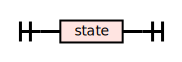

unexplored


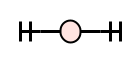

end


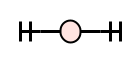

text


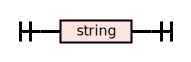

string


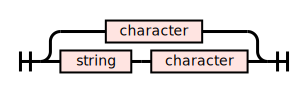

character


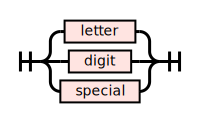

letter


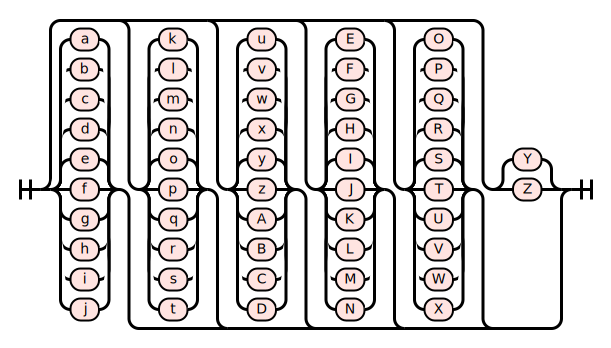

number


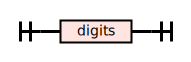

digits


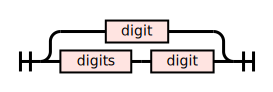

digit


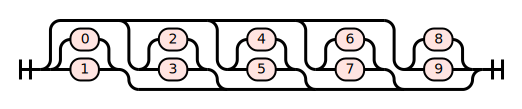

special


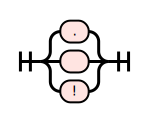

email


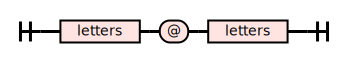

letters


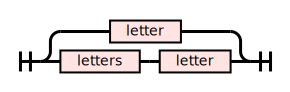

boolean


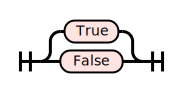

password


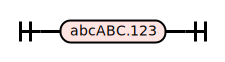

hidden


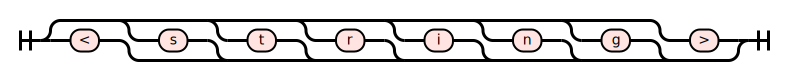

In [74]:
syntax_diagram(GUIGrammarMiner.GUI_GRAMMAR)

The method `mine_state_grammar()` goes through the actions mined from the page (using `mine_state_actions()`) and creates a grammar for the current state.  For each `click()` and `submit()` action, it assumes a new state follows, and introduces an appropriate state symbol into the grammar – a state symbol that now will be marked as `<unexplored>`, but will be expanded later as the appropriate state is seen.

In [75]:
class GUIGrammarMiner(GUIGrammarMiner):
    def new_state_symbol(self, grammar):
        return new_symbol(grammar, self.START_STATE)

    def mine_state_grammar(self, grammar={}, state_symbol=None):
        grammar = extend_grammar(self.GUI_GRAMMAR, grammar)

        if state_symbol is None:
            state_symbol = self.new_state_symbol(grammar)
            grammar[state_symbol] = []

        alternatives = []
        form = ""
        submit = None

        for action in self.mine_state_actions():
            if action.startswith("submit"):
                submit = action
                
            elif action.startswith("click"):
                link_target = self.new_state_symbol(grammar)
                grammar[link_target] = [self.UNEXPLORED_STATE]
                alternatives.append(action + '\n' + link_target)
                
            elif action.startswith("ignore"):
                pass

            else:  # fill(), check() actions
                if len(form) > 0:
                    form += '\n'
                form += action

        if submit is not None:
            if len(form) > 0:
                form += '\n'
            form += submit

        if len(form) > 0:
            form_target = self.new_state_symbol(grammar)
            grammar[form_target] = [self.UNEXPLORED_STATE]
            alternatives.append(form + '\n' + form_target)
            
        alternatives += [self.FINAL_STATE]

        grammar[state_symbol] = alternatives
        
        # Remove unused parts
        for nonterminal in unreachable_nonterminals(grammar):
            del grammar[nonterminal]

        assert is_valid_grammar(grammar)
        
        return grammar

Let us show `mine_state_grammar()` in action.  Here's the grammar for the home page:

In [76]:
gui_grammar_miner = GUIGrammarMiner(gui_driver)
state_grammar = gui_grammar_miner.mine_state_grammar()

From the start state (`<state>`), we can go and either click on "terms and conditions", ending in `<state-1>`, or fill out the form, ending in `<state-2>`.

In [77]:
state_grammar[GUIGrammarMiner.START_STATE]

["click('terms and conditions')\n<state-1>",
 "fill('city', '<text>')\ncheck('terms', <boolean>)\nfill('email', '<email>')\nfill('zip', '<number>')\nfill('name', '<text>')\nsubmit('submit')\n<state-2>",
 '<end>']

Both these states are yet unexplored:

In [78]:
state_grammar['<state-1>']

['<unexplored>']

In [79]:
state_grammar['<state-2>']

['<unexplored>']

In [80]:
state_grammar['<unexplored>']

['']

To better see the state structure, the function `fsm_diagram()` shows the resulting state grammar as a finite state machine.  (This assumes that the grammar actually encodes a state machine.)

In [81]:
from collections import deque

In [82]:
from bookutils import unicode_escape

In [83]:
def fsm_diagram(grammar, start_symbol=START_SYMBOL):
    from graphviz import Digraph
    from IPython.display import display
    
    def left_align(label):
        return dot_escape(label.replace('\n', r'\l')).replace(r'\\l', '\\l')

    dot = Digraph(comment="Grammar as Finite State Machine")

    symbols = deque([start_symbol])
    symbols_seen = set()
    
    while len(symbols) > 0:
        symbol = symbols.popleft()
        symbols_seen.add(symbol)
        dot.node(symbol, dot_escape(unicode_escape(symbol)))
        
        for expansion in grammar[symbol]:
            nts = nonterminals(expansion)
            if len(nts) > 0:
                target_symbol = nts[-1]
                if target_symbol not in symbols_seen:
                    symbols.append(target_symbol)

                label = expansion.replace(target_symbol, '')
                dot.edge(symbol, target_symbol, left_align(unicode_escape(label)))
                         
                
    return display(dot)

Here's our current grammar as a state machine.  We see that it nicely reflects what we can see from our Web server's home page:

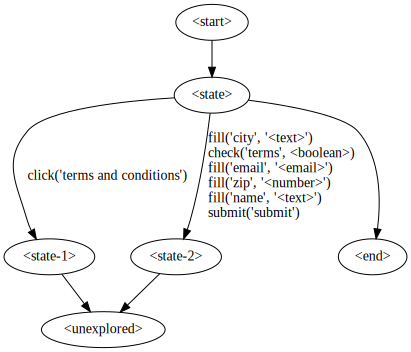

In [84]:
fsm_diagram(state_grammar)

Given the grammar, we can use any of our grammar fuzzers to create valid input sequences:

In [85]:
from GrammarFuzzer import GrammarFuzzer

In [86]:
gui_fuzzer = GrammarFuzzer(state_grammar)
while True:
    action = gui_fuzzer.fuzz()
    if action.find('submit(') > 0:
        break
print(action)

fill('city', '.')
check('terms', True)
fill('email', 'ov@i')
fill('zip', '9')
fill('name', 'v')
submit('submit')



These actions, however, must also be _executed_ such that we can explore the user interface.  This is what we do in the next section.

### Executing User Interface Actions

To execute actions, we introduce a `Runner` class, conveniently named `GUIRunner`.  The aim of its `run()` method is to execute the actions as given in an action string.  The way we do this is fairly simple: We introduce four methods named `fill()`, `check()`, `submit()` and `click()`, and run `exec()` on the action string to have the Python interpreter invoke these methods.

Running `exec()` on third-party input is dangerous, as the names of UI elements may contain valid Python code.  We restrict access to the four functions defined above, and also set `__builtins__` to the empty dictionary such that built-in Python functions are not available during `exec()`.  This will prevent accidents, but as we will see in the [chapter on information flow](InformationFlow.ipynb), it is still possible to inject Python code.  To prevent such injection attacks, we use `html.escape()` to quote angle and quote characters in all third-party strings.

In [87]:
from Fuzzer import Runner

In [88]:
class GUIRunner(Runner):
    def __init__(self, driver):
        self.driver = driver
        
    def run(self, inp):
        def fill(name, value):
            self.do_fill(html.unescape(name), html.unescape(value))
        def check(name, state):
            self.do_check(html.unescape(name), state)
        def submit(name):
            self.do_submit(html.unescape(name))
        def click(name):
            self.do_click(html.unescape(name))
        
        exec(inp, {'__builtins__': {}},
                  {'fill': fill, 'check': check, 'submit': submit, 'click': click})
        
        return inp, self.PASS

To identify elements in an action, we first search them by their name, and then by the displayed link text.

In [89]:
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import ElementClickInterceptedException, ElementNotInteractableException

In [90]:
class GUIRunner(GUIRunner):
    def find_element(self, name):
        try:
            return self.driver.find_element_by_name(name)
        except NoSuchElementException:
            return self.driver.find_element_by_link_text(name)

The implementations of the actions simply defer to the appropriate Selenium methods, introducing explicit delays such that the page can reload and refresh.

In [91]:
from selenium.webdriver.support.ui import WebDriverWait

In [92]:
class GUIRunner(GUIRunner):
    # Delays (in seconds)
    DELAY_AFTER_FILL = 0.1
    DELAY_AFTER_CHECK = 0.1
    DELAY_AFTER_SUBMIT = 1
    DELAY_AFTER_CLICK = 1

In [93]:
class GUIRunner(GUIRunner):
    def do_fill(self, name, value):
        element = self.find_element(name)
        element.send_keys(value)
        WebDriverWait(self.driver, self.DELAY_AFTER_FILL)

In [94]:
class GUIRunner(GUIRunner):
    def do_check(self, name, state):
        element = self.find_element(name)
        if bool(state) != bool(element.is_selected()):
            element.click()
        WebDriverWait(self.driver, self.DELAY_AFTER_CHECK)

In [95]:
class GUIRunner(GUIRunner):
    def do_submit(self, name):
        element = self.find_element(name)
        element.click()
        WebDriverWait(self.driver, self.DELAY_AFTER_SUBMIT)

In [96]:
class GUIRunner(GUIRunner):
    def do_click(self, name):
        element = self.find_element(name)
        element.click()
        WebDriverWait(self.driver, self.DELAY_AFTER_CLICK)

Let us try out `GUIRunner`.  We create a runner on our Web server, and let it execute a `fill()` action:

In [97]:
gui_driver.get(httpd_url)

In [98]:
gui_runner = GUIRunner(gui_driver)

In [99]:
gui_runner.run("fill('name', 'Walter White')")

("fill('name', 'Walter White')", 'PASS')

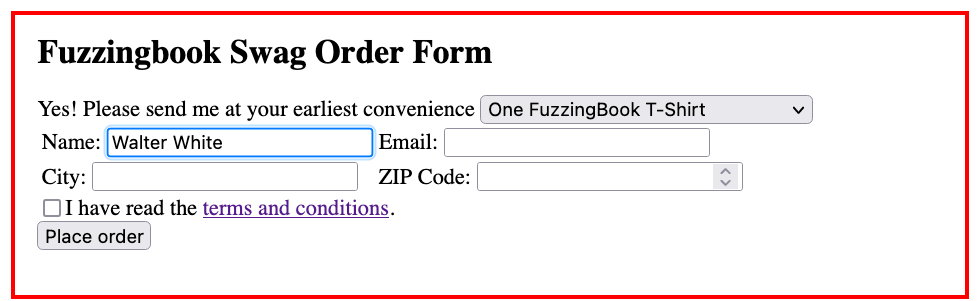

In [100]:
Image(gui_driver.get_screenshot_as_png())

A `submit()` action submits the order.  (Note that our Web server does no effort whatsoever to validate the form.)

In [101]:
gui_runner.run("submit('submit')")

("submit('submit')", 'PASS')

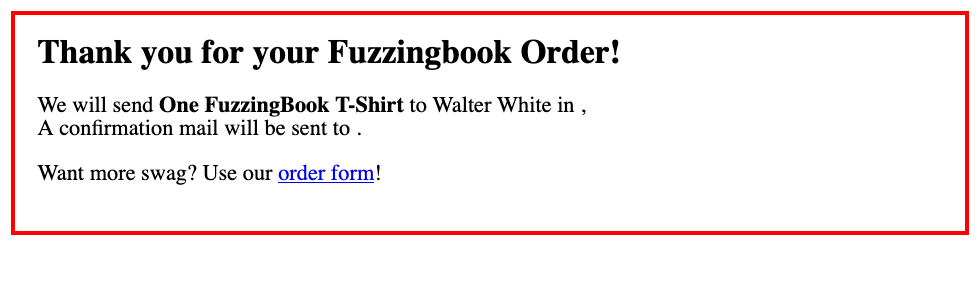

In [102]:
Image(gui_driver.get_screenshot_as_png())

Of course, we can also execute action sequences generated from the grammar.  This allows us to fill the form again and again, using values matching the type given in the form.

In [103]:
gui_driver.get(httpd_url)

In [104]:
gui_fuzzer = GrammarFuzzer(state_grammar)

In [105]:
while True:
    action = gui_fuzzer.fuzz()
    if action.find('submit(') > 0:
        break

In [106]:
print(action)

fill('city', '!')
check('terms', False)
fill('email', 'niZrQ@s')
fill('zip', '656')
fill('name', ' ')
submit('submit')



In [107]:
gui_runner.run(action)

("fill('city', '!')\ncheck('terms', False)\nfill('email', 'niZrQ@s')\nfill('zip', '656')\nfill('name', ' ')\nsubmit('submit')\n",
 'PASS')

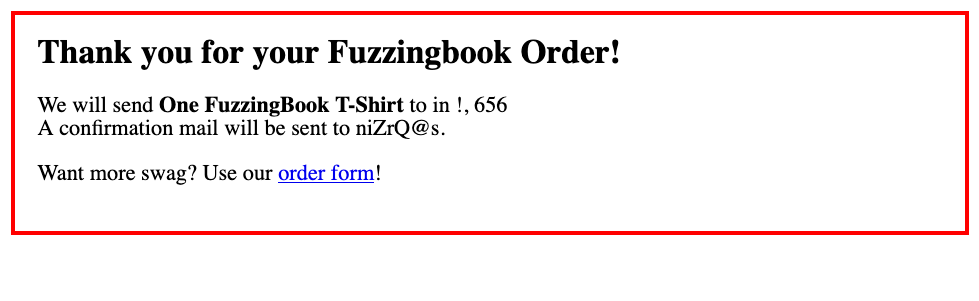

In [108]:
Image(gui_driver.get_screenshot_as_png())

## Exploring User Interfaces

So far, our grammar retrieval and execution of actions is limited to the current user interface state (i.e., the current page shown).  To systematically explore a user interface, we must explore all states, notably those ending in `<unexplored>` – and whenever we reach a new state, again retrieve its grammar such that we may be able to reach other states.  Since some states can only be reached by generating inputs, test generation and user interface exploration _take place at the same time._  

Consequently, we introduce a `GUIFuzzer` class, which generates inputs for all forms and follows all links, and which updates its grammar (i.e., its user interface model as a finite state machine) every time it encounters a new state. 

Exploring states and updating the grammar at the same time is a fairly complex operation, so we need to introduce quite a number of methods before we can put this to use.  The `GUIFuzzer` constructor sets three important attributes:

1. `state_symbol`: This holds the symbol of the current state (e.g. `<state-1>`).
2. `state`: This holds the set of actions for the current state, as returned by the `GUIGrammarMiner` method `mine_state_actions()`.
3. `states_seen`: This maps the states seen (as in `state`) to the respective symbols.

Let us show these three attributes after initialization.

In [109]:
from Grammars import is_nonterminal

In [110]:
from GrammarFuzzer import GrammarFuzzer

In [111]:
class GUIFuzzer(GrammarFuzzer):
    def __init__(self, driver, 
                 stay_on_host=True,
                 log_gui_exploration=False, 
                 disp_gui_exploration=False, 
                 **kwargs):
        self.driver = driver
        self.miner = GUIGrammarMiner(driver)
        self.stay_on_host = True
        self.log_gui_exploration = log_gui_exploration
        self.disp_gui_exploration = disp_gui_exploration
        self.initial_url = driver.current_url

        self.states_seen = {}  # Maps states to symbols
        self.state_symbol = GUIGrammarMiner.START_STATE
        self.state = self.miner.mine_state_actions()
        self.states_seen[self.state] = self.state_symbol
        
        grammar = self.miner.mine_state_grammar()
        super().__init__(grammar, **kwargs)

In [112]:
gui_driver.get(httpd_url)

The initial state symbol is always `<state>`:

In [113]:
gui_fuzzer = GUIFuzzer(gui_driver)
gui_fuzzer.state_symbol

'<state>'

The current state is characterized by the available UI actions:

In [114]:
gui_fuzzer.state

frozenset({"check('terms', <boolean>)",
           "click('terms and conditions')",
           "fill('city', '<text>')",
           "fill('email', '<email>')",
           "fill('name', '<text>')",
           "fill('zip', '<number>')",
           "submit('submit')"})

`states_seen` maps this state to its symbol:

In [115]:
gui_fuzzer.states_seen[gui_fuzzer.state]

'<state>'

The `restart()` method gets us back to the initial URL and resets the state.  This is what we use with every new exploration.

In [116]:
class GUIFuzzer(GUIFuzzer):
    def restart(self):
        self.driver.get(self.initial_url)
        self.state = GUIGrammarMiner.START_STATE

When producing a sequence of actions from the grammar, we want to know which final state we are to be in.  We can retrieve this path from the _derivation tree_ produced – it is the last symbol being expanded.

In [117]:
while True:
    action = gui_fuzzer.fuzz()
    if action.find('click(') >= 0:
        break

In [118]:
from GrammarFuzzer import display_tree

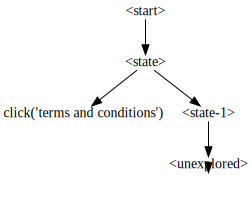

In [119]:
tree = gui_fuzzer.derivation_tree
display_tree(tree)

In [120]:
class GUIFuzzer(GUIFuzzer):
    def fsm_path(self, tree):
        """Return sequence of state symbols"""
        (node, children) = tree
        if node == GUIGrammarMiner.UNEXPLORED_STATE:
            return []
        elif children is None or len(children) == 0:
            return [node]
        else:
            return [node] + self.fsm_path(children[-1])

This is the path in the finite state machine towards the "fuzzed" state:

In [121]:
gui_fuzzer = GUIFuzzer(gui_driver)
gui_fuzzer.fsm_path(tree)

['<start>', '<state>', '<state-1>']

This is its last element:

In [122]:
class GUIFuzzer(GUIFuzzer):
    def fsm_last_state_symbol(self, tree):
        """Return current (expected) state symbol"""
        for state in reversed(self.fsm_path(tree)):
            if is_nonterminal(state):
                return state
        assert False

In [123]:
gui_fuzzer = GUIFuzzer(gui_driver)
gui_fuzzer.fsm_last_state_symbol(tree)

'<state-1>'

As we run (`run()`) the fuzzer, we create an action (via `fuzz()`) and retrieve and update the state symbol (`state_symbol`) we are supposed to be in after running this action.  After actually running the action in the given `GUIRunner`, we retrieve and update the current state, using `update_state()`.

In [124]:
class GUIFuzzer(GUIFuzzer):
    def run(self, runner):
        assert isinstance(runner, GUIRunner)
        
        self.restart()
        action = self.fuzz()
        self.state_symbol = self.fsm_last_state_symbol(self.derivation_tree)

        if self.log_gui_exploration:
            print("Action", action.strip(), "->", self.state_symbol)

        result, outcome = runner.run(action)
        
        if self.state_symbol != GUIGrammarMiner.FINAL_STATE:
            self.update_state()

        return self.state_symbol, outcome

When updating the current state, we check whether we are in a new or in a previously seen state, and invoke `update_new_state()` or `update_existing_state()`, respectively.

In [125]:
class GUIFuzzer(GUIFuzzer):
    def update_state(self):
        if self.disp_gui_exploration:
            display(Image(self.driver.get_screenshot_as_png()))

        self.state = self.miner.mine_state_actions()
        if self.state not in self.states_seen:
            self.states_seen[self.state] = self.state_symbol
            self.update_new_state()
        else:
            self.update_existing_state()

Finding a new state means that we mine a new grammar for the newly found state, and update our existing grammar with it.

In [126]:
class GUIFuzzer(GUIFuzzer):
    def set_grammar(self, new_grammar):
        self.grammar = new_grammar
        
        if self.disp_gui_exploration and rich_output():
            display(fsm_diagram(self.grammar))

In [127]:
class GUIFuzzer(GUIFuzzer):
    def update_new_state(self):
        if self.log_gui_exploration:
            print("In new state", unicode_escape(self.state_symbol), unicode_escape(repr(self.state)))

        state_grammar = self.miner.mine_state_grammar(grammar=self.grammar, 
                                                      state_symbol=self.state_symbol)
        del state_grammar[START_SYMBOL]
        del state_grammar[GUIGrammarMiner.START_STATE]
        self.set_grammar(extend_grammar(self.grammar, state_grammar))

If we find an existing state, we need to _merge_ both states.  If, for instance, we find that we are in existing `<state-1>` rather than in the expected `<state-3>`, we replace all instances of `<state-3>` in the grammar by `<state-1>`.  The method `replace_symbol()` takes care of the renaming; `update_existing_state()` sets the grammar accordingly.

In [128]:
from Grammars import exp_string, exp_opts

In [129]:
def replace_symbol(grammar, old_symbol, new_symbol):
    """Return a grammar in which all occurrences of `old_symbol` are replaced by `new_symbol`"""
    new_grammar = {}
    
    for symbol in grammar:
        new_expansions = []
        for expansion in grammar[symbol]:
            new_expansion_string = exp_string(expansion).replace(old_symbol, new_symbol)
            if len(exp_opts(expansion)) > 0:
                new_expansion = (new_expansion_string, exp_opts(expansion))
            else:
                new_expansion = new_expansion_string
            new_expansions.append(new_expansion)
                
        new_grammar[symbol] = new_expansions
        
    # Remove unused parts
    for nonterminal in unreachable_nonterminals(new_grammar):
        del new_grammar[nonterminal]

    return new_grammar

In [130]:
class GUIFuzzer(GUIFuzzer):            
    def update_existing_state(self):
        if self.log_gui_exploration:
            print("In existing state", self.states_seen[self.state])

        if self.state_symbol != self.states_seen[self.state]:
            if self.log_gui_exploration:
                print("Replacing expected state %s by %s" %
                      (self.state_symbol, self.states_seen[self.state]))
            
            new_grammar = replace_symbol(self.grammar, self.state_symbol, 
                                         self.states_seen[self.state])
            self.state_symbol = self.states_seen[self.state]
            self.set_grammar(new_grammar)

This concludes our definitions for `GUIFuzzer`.  We can now put it to use, enabling its logging mechanisms to see what it is doing.

In [131]:
gui_driver.get(httpd_url)

In [132]:
gui_fuzzer = GUIFuzzer(gui_driver, log_gui_exploration=True, disp_gui_exploration=True)

Running it the first time yields a new state:

Action fill('city', '.')
check('terms', False)
fill('email', 'E@L')
fill('zip', '834')
fill('name', '7')
submit('submit') -> <state-2>


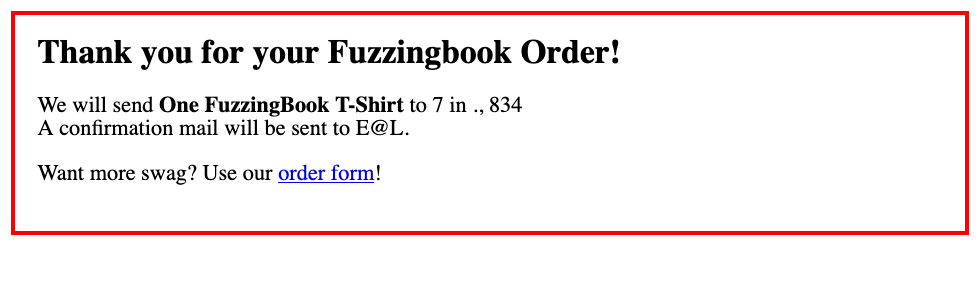

In new state <state-2> frozenset({"click('order form')"})


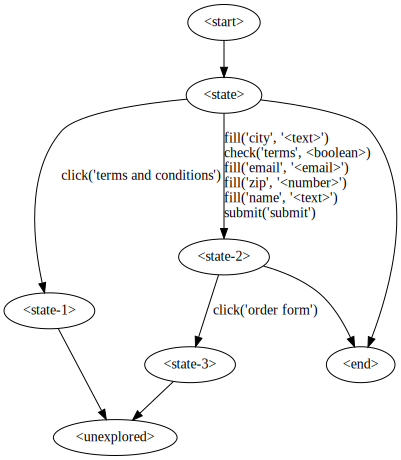

None

('<state-2>', 'PASS')

In [133]:
gui_fuzzer.run(gui_runner)

The next actions fill out the order form.

In [134]:
gui_fuzzer.run(gui_runner)

Action  -> <end>


('<end>', 'PASS')

In [135]:
gui_fuzzer.run(gui_runner)

Action fill('city', ' !')
check('terms', True)
fill('email', 'd@eaM')
fill('zip', '6')
fill('name', 'j')
submit('submit') -> <end>


('<end>', 'PASS')

At this point, our GUI model is fairly complete already.  In order to systematically cover _all_ states, random exploration is not efficient enough, though.

## Covering States

During exploration as well as during testing, we want to _cover_ all states and transitions between states.  How can we achieve this?

It turns out that _we already have this._  Our `GrammarCoverageFuzzer` from the [chapter on coverage-based grammar testing](GrammarCoverageFuzzer.ipynb) strives to systematically _cover all expansion alternatives_ in a grammar.  In the finite state model, these expansion alternatives translate into transitions between states.  Hence, applying the coverage strategy from `GrammarCoverageFuzzer` to our state grammars would automatically cover one transition after another.

How do we get these features into `GUIFuzzer`?  Using _multiple inheritance_, we can create a class `GUICoverageFuzzer` which combines the `run()` method from `GUIFuzzer` with the coverage choices from `GrammarCoverageFuzzer`.

In [136]:
from GrammarCoverageFuzzer import GrammarCoverageFuzzer

In [137]:
from bookutils import inheritance_conflicts

Since the `__init__()` constructor is defined in both superclasses, we need to define our own constructor that serves both:

In [138]:
inheritance_conflicts(GUIFuzzer, GrammarCoverageFuzzer)

['__init__']

In [139]:
class GUICoverageFuzzer(GUIFuzzer, GrammarCoverageFuzzer):
    def __init__(self, *args, **kwargs):
        GUIFuzzer.__init__(self, *args, **kwargs)
        self.reset_coverage()

With `GUICoverageFuzzer`, we can set up a method `explore_all()` that keeps on running the fuzzer until there are no unexplored states anymore:

In [140]:
class GUICoverageFuzzer(GUICoverageFuzzer):            
    def explore_all(self, runner, max_actions=100):
        actions = 0
        while GUIGrammarMiner.UNEXPLORED_STATE in self.grammar and actions < max_actions:
            actions += 1
            if self.log_gui_exploration:
                print("Run #" + repr(actions))
            try:
                self.run(runner)
            except ElementClickInterceptedException:
                pass
            except ElementNotInteractableException:
                pass
            except NoSuchElementException:
                pass

Let us use this to fully explore our Web server:

In [141]:
gui_driver.get(httpd_url)

In [142]:
gui_fuzzer = GUICoverageFuzzer(gui_driver)

In [143]:
gui_fuzzer.explore_all(gui_runner)

Success! We have covered all states:

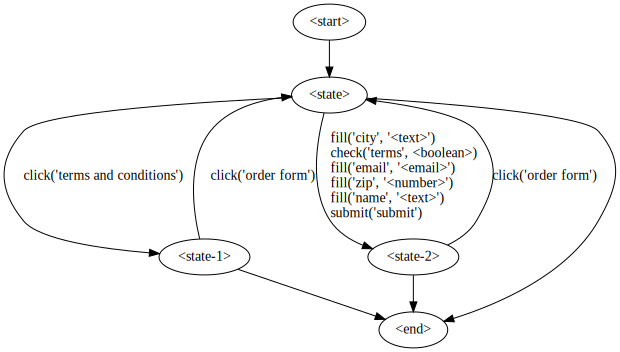

In [144]:
fsm_diagram(gui_fuzzer.grammar)

We can retrieve the expansions covered so far, which of course cover all states.

In [145]:
gui_fuzzer.covered_expansions

{'<boolean> -> False',
 '<boolean> -> True',
 '<character> -> <digit>',
 '<character> -> <letter>',
 '<character> -> <special>',
 '<digit> -> 1',
 '<digit> -> 2',
 '<digit> -> 3',
 '<digit> -> 4',
 '<digit> -> 7',
 '<digits> -> <digit>',
 '<digits> -> <digits><digit>',
 '<email> -> <letters>@<letters>',
 '<end> -> ',
 '<letter> -> A',
 '<letter> -> G',
 '<letter> -> L',
 '<letter> -> O',
 '<letter> -> W',
 '<letter> -> Z',
 '<letter> -> d',
 '<letter> -> f',
 '<letter> -> i',
 '<letter> -> k',
 '<letter> -> n',
 '<letter> -> q',
 '<letter> -> t',
 '<letter> -> y',
 '<letters> -> <letter>',
 '<letters> -> <letters><letter>',
 '<number> -> <digits>',
 '<special> -> .',
 '<start> -> <state>',
 '<state-1> -> <end>',
 '<state-1> -> <unexplored>',
 "<state-1> -> click('order form')\n<state-4>",
 "<state-1> -> click('order form')\n<state>",
 '<state-2> -> <end>',
 '<state-2> -> <unexplored>',
 "<state-2> -> click('order form')\n<state-3>",
 '<state-3> -> <unexplored>',
 '<state-4> -> <unexplo

Still, we haven't seen all expansions covered.  A few digits and letters remain to be used.

In [146]:
gui_fuzzer.missing_expansion_coverage()

{'<digit> -> 0',
 '<digit> -> 5',
 '<digit> -> 6',
 '<digit> -> 8',
 '<digit> -> 9',
 '<letter> -> B',
 '<letter> -> C',
 '<letter> -> D',
 '<letter> -> E',
 '<letter> -> F',
 '<letter> -> H',
 '<letter> -> I',
 '<letter> -> J',
 '<letter> -> K',
 '<letter> -> M',
 '<letter> -> N',
 '<letter> -> P',
 '<letter> -> Q',
 '<letter> -> R',
 '<letter> -> S',
 '<letter> -> T',
 '<letter> -> U',
 '<letter> -> V',
 '<letter> -> X',
 '<letter> -> Y',
 '<letter> -> a',
 '<letter> -> b',
 '<letter> -> c',
 '<letter> -> e',
 '<letter> -> g',
 '<letter> -> h',
 '<letter> -> j',
 '<letter> -> l',
 '<letter> -> m',
 '<letter> -> o',
 '<letter> -> p',
 '<letter> -> r',
 '<letter> -> s',
 '<letter> -> u',
 '<letter> -> v',
 '<letter> -> w',
 '<letter> -> x',
 '<letter> -> z',
 '<special> ->  ',
 '<special> -> !',
 "<state-2> -> click('order form')\n<state>"}

Running the fuzzer again and again will eventually cover these expansions too, leading to letter and digit coverage within the order form.

## Exploring Large Sites

Our GUI fuzzer is robust enough to handle exploration even on nontrivial sites such as [fuzzingbook.org](https://www.fuzzingbook.org).  Let us demonstrate this:

In [147]:
gui_driver.get("https://www.fuzzingbook.org/html/Fuzzer.html")

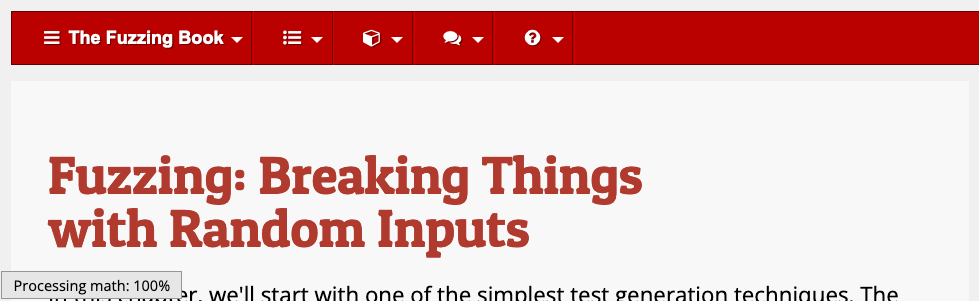

In [148]:
Image(gui_driver.get_screenshot_as_png())

In [149]:
book_runner = GUIRunner(gui_driver)

In [150]:
book_fuzzer = GUICoverageFuzzer(gui_driver, log_gui_exploration=True)  # , disp_gui_exploration=True)

We explore the first few states of the site, defined in `ACTIONS`:

In [151]:
ACTIONS = 5

In [152]:
book_fuzzer.explore_all(book_runner, max_actions=ACTIONS)

Run #1
Action click('') -> <state-18>
Run #2
Action click('Intro_Testing') -> <state-6>
Run #3
Action click('reduce failing inputs for efficient debugging') -> <state-7>
Run #4
Action click('A Fuzzing Architecture') -> <state-2>
In existing state <state>
Replacing expected state <state-2> by <state>
Run #5
Action click('The Fuzzing Book') -> <state-3>
In new state <state-3> frozenset({"ignore('MIT License')", "click('chapter on information flow')", "click('A Fuzzing Architecture')", "ignore('tempfile')", "ignore('bookutils')", "ignore('os')", "ignore('Imprint')", "ignore('MyPy')", "click('I\nWhetting Your Appetite')", "click('IV\nSemantical Fuzzing')", "click('Index (beta)')", "ignore('subprocess')", "click('The Fuzzing Book')", "click('Appendices')", "ignore('Miller et al, 1990')", "click('Introduction to Testing')", "click('VI\nManaging Fuzzing')", "ignore('red-black tree')", "click('runtime verification')", "ignore('Creative Commons Attribution-NonCommercial-ShareAlike 4.0 Internati

After the first `ACTIONS` actions already, we can see that the finite state model is quite complex, with dozens of transitions still left to explore.  Most of the yet unexplored states will eventually merge with existing states, yielding one state per chapter.  Still, following _all_ links on _all_ pages will take quite some time.

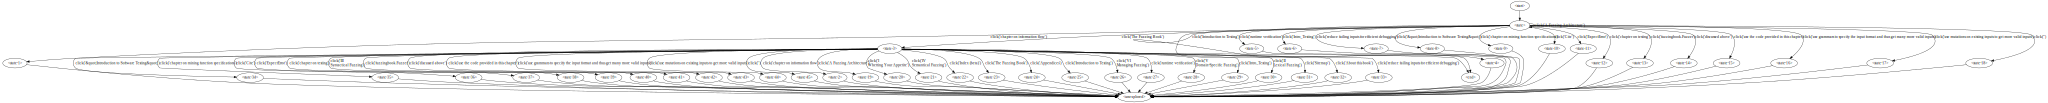

In [153]:
# Inspect this graph in the notebook to see it in full glory
fsm_diagram(book_fuzzer.grammar)

We now have all the basic capabilities we need: We can automatically explore large Web sites; we can explore "deep" functionality by filling out forms; and we can have our coverage-based fuzzer automatcially focus on yet unexplored states.  Still, there is a lot more one can do; the [exercises](#Exercises) will give you some ideas.

In [154]:
gui_driver.quit()

## Synopsis

This chapter demonstrates how to programmatically interact with user interfaces, using Selenium on Web browsers.  It provides an experimental  `GUICoverageFuzzer` class that automatically explores a user interface by systematically interacting with all available user interface elements.

The function `start_webdriver()` starts a headless Web browser in the background and returns a _GUI driver_ as handle for further communication.

In [155]:
gui_driver = start_webdriver()

We let it the browser open the URL of the server we want to investigate (in this case, the vulnerable server from [the chapter on Web fuzzing](WebFuzzer.ipynb)) and obtain a screen shot.

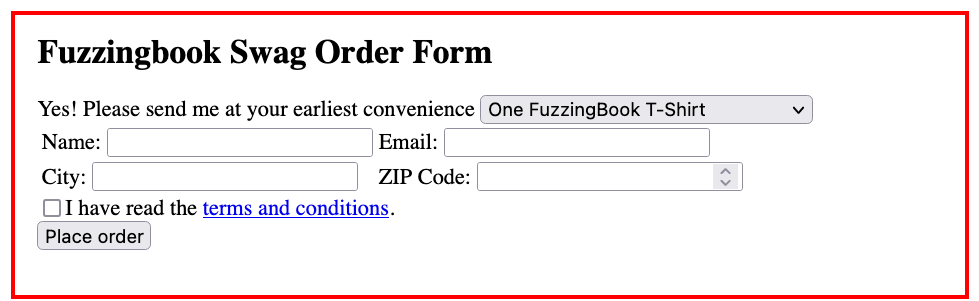

In [156]:
gui_driver.get(httpd_url)
Image(gui_driver.get_screenshot_as_png())

The `GUICoverageFuzzer` class explores the user interface and builds a _grammar_ that encodes all states as well as the user interactions required to move from one state to the next.  It is paired with a `GUIRunner` which interacts with the GUI driver.

In [157]:
gui_fuzzer = GUICoverageFuzzer(gui_driver)

In [158]:
gui_runner = GUIRunner(gui_driver)

The `explore_all()` method extracts all states and all transitions from a Web user interface.

In [159]:
gui_fuzzer.explore_all(gui_runner)

The grammar embeds a finite state automation and is best visualized as such.

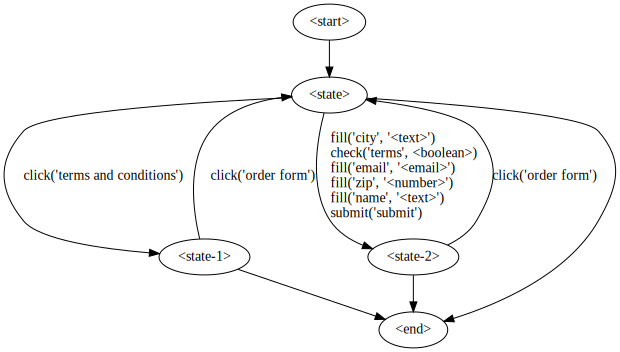

In [160]:
fsm_diagram(gui_fuzzer.grammar)

The GUI Fuzzer `fuzz()` method produces sequences of interactions that follow paths through the finite state machine.  Since `GUICoverageFuzzer` is derived from `CoverageFuzzer` (see the [chapter on coverage-based grammar fuzzing](GrammarCoverageFuzzer.ipynb)), it automatically covers (a) as many transitions between states as well as (b) as many form elements as possible.  In our case, the first set of actions explores the transition via the "order form" link; the second set then goes until the "<end>" state.

In [161]:
gui_driver.get(httpd_url)
actions = gui_fuzzer.fuzz()
print(actions)

fill('city', 'q')
check('terms', False)
fill('email', 'H@K')
fill('zip', '75')
fill('name', 'Fs')
submit('submit')
click('order form')
click('terms and conditions')
click('order form')
fill('city', 'g')
check('terms', True)
fill('email', 'D@I')
fill('zip', '8')
fill('name', 'X')
submit('submit')



These actions can be fed into the GUI runner, which will execute them on the given GUI driver.

In [162]:
gui_driver.get(httpd_url)
result, outcome = gui_runner.run(actions)

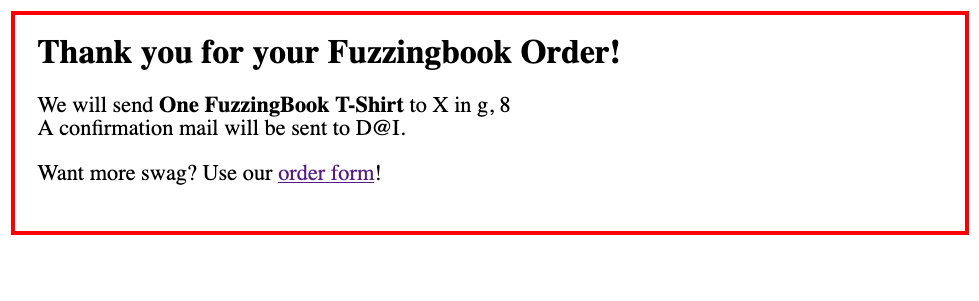

In [163]:
Image(gui_driver.get_screenshot_as_png())

Further invocations of `fuzz()` will further cover the model – for instance, exploring the terms and conditions.

A tool like `GUICoverageFuzzer` will provide "deep" exploration of user interfaces, even filling out forms to explore what is behind them. Keep in mind, though, that `GUICoverageFuzzer` is experimental: It only supports a subset of HTML form and link features, and does not take JavaScript into account.

## Lessons Learned

* _Selenium_ is a powerful framework for interacting with user interfaces, especially Web-based user interfaces.
* A _finite state model_ can encode user interface states and transitions.
* Encoding user interface models into a _grammar_ integrates generating text (for forms) and generating user interactions (for navigating)
* To systematically explore a user interface, cover all _state transitions_, which is equivalent to covering all _expansion alternatives_ in the equivalent grammar.

We are done, so we clean up. We shut down our Web server, quit the Web driver (and the associated browser), and finally clean up temporary files left by Selenium.

In [164]:
httpd_process.terminate()

In [165]:
gui_driver.quit()

In [166]:
import os

In [167]:
for temp_file in [ORDERS_DB, "geckodriver.log", "ghostdriver.log"]:
    if os.path.exists(temp_file):
        os.remove(temp_file)

## Next Steps

From here, you can learn how to

* [fuzz in the large](FuzzingInTheLarge.ipynb). running a myriad of fuzzers on the same system

## Background

Automatic testing of graphical user interfaces is a rich field – in research as in practice.

Coverage criteria for GUIs as well as how to achieve them were first discussed in \cite{Memon2001}.  Memon also introduced the concept of *GUI Ripping* \cite{Memon2003} – the process in which the software's GUI is automatically traversed by interacting with all its user interface elements.

The CrawlJax tool \cite{Mesbah2012} uses dynamic state changes in Web user interfaces to identify candidate elements to interact with.  As our approach above, it uses the set of interactable user interface elements as a state in a finite-state model.

The [Alex framework](https://learnlib.github.io/alex/) uses a similar approach to learn automata for web applications.  Starting from a set of test inputs, it produces a mixed-mode behavioral model of the application.

## Exercises

As powerful as our GUI fuzzer is at this point, there are still several possibilities left for further optimization and extension.  Here are some ideas to get you started.  Enjoy user interface fuzzing!

### Exercise 1: Stay in Local State

Rather than having each `run()` start at the very beginning, have the miner start from the current state and explore states reachable from there.

### Exercise 2: Going Back

Make use of the web driver `back()` method and go back to an earlier state, from which we could again start exploration.  (Note that a "back" functionality may not be available on non-Web user interfaces.)

### Exercise 3: Avoiding Bad Form Values

Detect that some form values are _invalid_, such that the miner does not produce them again.

### Exercise 4: Saving Form Values

Save _successful_ form values, such that the tester does not have to infer them again and again.

### Exercise 5: Same Names, Same States

When the miner finds a link with a name it has already seen, it is likely to lead to a state already seen, too; therefore, one could give its exploration a lower priority.

### Exercise 6: Combinatorial Coverage

Extend the grammar miner such that for every boolean value, there is a separate value to be covered.

### Exercise 7: Implicit Delays

Rather than using _explicit_ (given) delays, use _implicit_ delays and wait for specific elements to appear. these elements could stem from previous explorations of the state.

### Exercise 8: Oracles

Extend the grammar miner such that it also produces _oracles_ – for instance, checking for the presence of specific UI elements.

### Exercise 9: More UI Elements

Run the miner on a Web site of your choice.  Find out which other types of user interface elements and actions need to be supported.